### Welcome to go through our final project!
### We attempt to use machine learning algorithms to predict 'backorder' on Walmart's garment products. This notebook is divided into three main parts: feature engineering, modelling and evaluation. We have cleaned the data beforehand for the code below.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from collections import Counter
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import pipeline as pl
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## 1. Feature Engineering

### 1.1. Interaction Terms (Categorical Variables)

In [2]:
# We have cleaned the dataset beforehand for this code file.
df = pd.read_csv("CleanedData.csv")

In [3]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
to_cross = ['potential_issue=Yes', 'deck_risk=Yes',
       'oe_constraint=Yes', 'ppap_risk=Yes', 'stop_auto_buy=Yes',
       'rev_stop=Yes']
crossed_feats = poly.fit_transform(df[to_cross].values)


#Convert to Pandas DataFrame and merge to original dataset
crossed_feats = pd.DataFrame(crossed_feats)
crossed_feats.columns= poly.get_feature_names(df[to_cross].columns)

In [4]:
df = pd.concat([df, crossed_feats], axis=1)
df = df.loc[:,~df.columns.duplicated()]

In [5]:
df = df.loc[:,['national_inv',
               'lead_time',
               'in_transit_qty',
               'forecast_3_month',
               'forecast_6_month',
               'forecast_9_month',
               'sales_1_month',
               'sales_3_month',
               'sales_6_month',
               'sales_9_month',
               'min_bank',
               'potential_issue=Yes',
               'pieces_past_due',
               'perf_6_month_avg',
               'perf_12_month_avg',
               'local_bo_qty',
               'deck_risk=Yes',
               'oe_constraint=Yes',
               'ppap_risk=Yes',
               'stop_auto_buy=Yes',
               'rev_stop=Yes',
               'went_on_backorder=Yes',
              
               'potential_issue=Yes deck_risk=Yes',
               'potential_issue=Yes oe_constraint=Yes',
               'potential_issue=Yes ppap_risk=Yes',
               'potential_issue=Yes stop_auto_buy=Yes',
               'potential_issue=Yes rev_stop=Yes',
               
               'deck_risk=Yes oe_constraint=Yes',
               'deck_risk=Yes ppap_risk=Yes',
               'deck_risk=Yes stop_auto_buy=Yes',
               'deck_risk=Yes rev_stop=Yes',
              
               'oe_constraint=Yes ppap_risk=Yes',
               'oe_constraint=Yes stop_auto_buy=Yes',
               'oe_constraint=Yes rev_stop=Yes',
             
               'ppap_risk=Yes stop_auto_buy=Yes',
               'ppap_risk=Yes rev_stop=Yes',
             
               'stop_auto_buy=Yes rev_stop=Yes']]

In [6]:
print("The dataset has {} rows and {} columns - after adding interaction terms.".format(*df.shape))

The dataset has 1586967 rows and 37 columns - after adding interaction terms.


### 1.2. Polynomial features (Numeric variables)

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
to_power = ['national_inv',
               'lead_time',
               'in_transit_qty',
               'forecast_3_month',
               'forecast_6_month',
               'forecast_9_month',
               'sales_1_month',
               'sales_3_month',
               'sales_6_month',
               'sales_9_month',
               'min_bank',
               'pieces_past_due',
               'perf_6_month_avg',
               'perf_12_month_avg',
               'local_bo_qty']
power = poly.fit_transform(df[to_power].values)


#Convert to Pandas DataFrame and merge to original dataset
power= pd.DataFrame(power)
power.columns= poly.get_feature_names(df[to_power].columns)

In [8]:
df = pd.concat([df, power], axis=1)
df = df.loc[:,~df.columns.duplicated()]
df = df.loc[:,['national_inv',
               'lead_time',
               'in_transit_qty',
               'forecast_3_month',
               'forecast_6_month',
               'forecast_9_month',
               'sales_1_month',
               'sales_3_month',
               'sales_6_month',
               'sales_9_month',
               'min_bank',
               'potential_issue=Yes',
               'pieces_past_due',
               'perf_6_month_avg',
               'perf_12_month_avg',
               'local_bo_qty',
               'deck_risk=Yes',
               'oe_constraint=Yes',
               'ppap_risk=Yes',
               'stop_auto_buy=Yes',
               'rev_stop=Yes',
               'went_on_backorder=Yes',
              
               'potential_issue=Yes deck_risk=Yes',
               'potential_issue=Yes oe_constraint=Yes',
               'potential_issue=Yes ppap_risk=Yes',
               'potential_issue=Yes stop_auto_buy=Yes',
               'potential_issue=Yes rev_stop=Yes',
               
               'deck_risk=Yes oe_constraint=Yes',
               'deck_risk=Yes ppap_risk=Yes',
               'deck_risk=Yes stop_auto_buy=Yes',
               'deck_risk=Yes rev_stop=Yes',
              
               'oe_constraint=Yes ppap_risk=Yes',
               'oe_constraint=Yes stop_auto_buy=Yes',
               'oe_constraint=Yes rev_stop=Yes',
             
               'ppap_risk=Yes stop_auto_buy=Yes',
               'ppap_risk=Yes rev_stop=Yes',
             
               'stop_auto_buy=Yes rev_stop=Yes',
               
               'national_inv^2',
               'lead_time^2',
               'in_transit_qty^2',
               'forecast_3_month^2',
               'forecast_6_month^2',
               'forecast_9_month^2',
               'sales_1_month^2',
               'sales_3_month^2',
               'sales_6_month^2',
               'sales_9_month^2',
               'min_bank^2',
               'pieces_past_due^2',
               'perf_6_month_avg^2',
               'perf_12_month_avg^2',
               'local_bo_qty^2'
              ]]

In [9]:
print("The dataset has {} rows and {} columns - after adding polynomial features.".format(*df.shape))

The dataset has 1586967 rows and 52 columns - after adding polynomial features.


### 1.3. Feature Engineering Based on Business Understanding

In [10]:
df['forecast_mean']=(df['forecast_3_month']+df['forecast_6_month']+df['forecast_9_month'])/18
df['sales_mean']=(df['sales_1_month']+df['sales_3_month']+df['sales_6_month']+df['sales_9_month'])/19
print("The dataset has {} rows and {} columns - after adding business understanding features.".format(*df.shape))

The dataset has 1586967 rows and 54 columns - after adding business understanding features.


## 2. Modelling

### 2.1. Define feature set and target variable

In [11]:
# define our target
target = df[["went_on_backorder=Yes"]]

# define our features 
features = df.drop(["went_on_backorder=Yes"], axis=1)

### 2.2. Choose sampling technique

In [12]:
# Create X and y arrays
X = np.asmatrix(features.values)
y = np.asmatrix(target.values)

### 2.2.1 SMOTE

Show fpr  ----------------------------
[0.00000000e+00 3.17258883e-06 5.39340102e-05 ... 9.99631980e-01
 9.99895305e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.6530785137650446
Show store_Roc_Auc   -----------------------
[0.65307851 0.         0.         0.         0.        ]
Show fpr  ----------------------------
[0.00000000e+00 3.17258883e-06 9.51776650e-06 ... 9.99663706e-01
 9.99869924e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.6313916393174278
Show store_Roc_Auc   -----------------------
[0.65307851 0.63139164 0.         0.         0.        ]
Show fpr  ----------------------------
[0.00000000e+00 3.17258883e-06 2.22081218e-05 ... 9.98362944e-01
 9.99879442e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.6400695177433505
Show store_Roc_Auc   ----

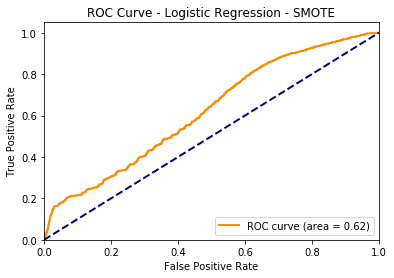

In [14]:
# Apply the random under-sampling
pipeline = pl.make_pipeline(os.SMOTE(),linear_model.LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    random_state=0)
    )


n_folds = 5
store_Roc_Auc = np.zeros(n_folds)

# Split to test and train set
results=[]
skf = StratifiedKFold(n_splits=n_folds)
aaa = 0
for train_index, test_index in skf.split(X,y):
    probas = pipeline.fit(X[train_index], y[train_index]).predict_proba(X[test_index])
    preds = probas[:, 1]
    fpr, tpr, threshold = roc_curve(y[test_index], preds)

    print("Show fpr  ----------------------------")
    print(fpr)
    print("Show tpr -----------------------------")
    print(tpr)


    roc_auc = auc(fpr, tpr)

    results.append(roc_auc)
    print("Show roc_auc   -----------------------")
    print(roc_auc)
    
    store_Roc_Auc[aaa] = roc_auc
    print("Show store_Roc_Auc   -----------------------")
    print(store_Roc_Auc)
    aaa = aaa+1

roc_auc = auc(fpr, tpr)

# # Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - SMOTE')
plt.legend(loc="lower right")
plt.show()

### 2.2.2 RUS

Show fpr  ----------------------------
[0.00000000e+00 7.61421320e-05 2.98223350e-04 ... 9.98819797e-01
 9.99603426e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.7856239349992364
Show store_Roc_Auc   -----------------------
[0.78562393 0.         0.         0.         0.        ]
Show fpr  ----------------------------
[0.00000000e+00 9.51776650e-05 1.07868020e-04 ... 9.99612944e-01
 9.99847716e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.717882241282177
Show store_Roc_Auc   -----------------------
[0.78562393 0.71788224 0.         0.         0.        ]
Show fpr  ----------------------------
[0.00000000e+00 3.17258883e-05 3.80710660e-05 ... 9.98435914e-01
 9.99901650e-01 1.00000000e+00]
Show tpr -----------------------------
[0. 0. 0. ... 1. 1. 1.]
Show roc_auc   -----------------------
0.8004952999969908
Show store_Roc_Auc   -----

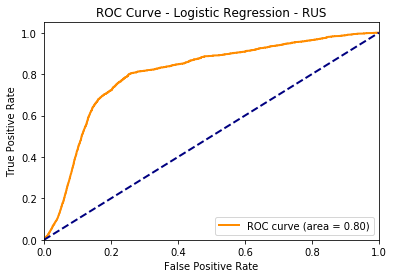

In [13]:
# Apply the random under-sampling
pipeline = pl.make_pipeline(us.RandomUnderSampler(),linear_model.LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    random_state=0)
    )


n_folds = 5
store_Roc_Auc = np.zeros(n_folds)

# Split to test and train set
results=[]
skf = StratifiedKFold(n_splits=n_folds)
aaa = 0
for train_index, test_index in skf.split(X,y):
    probas = pipeline.fit(X[train_index], y[train_index]).predict_proba(X[test_index])
    preds = probas[:, 1]
    fpr, tpr, threshold = roc_curve(y[test_index], preds)

    print("Show fpr  ----------------------------")
    print(fpr)
    print("Show tpr -----------------------------")
    print(tpr)


    roc_auc = auc(fpr, tpr)

    results.append(roc_auc)
    print("Show roc_auc   -----------------------")
    print(roc_auc)
    
    store_Roc_Auc[aaa] = roc_auc
    print("Show store_Roc_Auc   -----------------------")
    print(store_Roc_Auc)
    aaa = aaa+1

roc_auc = auc(fpr, tpr)

# # Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - RUS')
plt.legend(loc="lower right")
plt.show()

In [14]:
# So we chose to use RUS to balance our dataset.
rus = us.RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(features, target)

### 2.3. Feature Selection

### 2.3.1 The first thing we try is selecting features based on correlation.
We keep the feature with absolute correlation values larger than 1.

In [6]:
# Look at correlation matrix.
df = pd.read_csv("features.csv")
corrmatrix = df.corr()
corrmatrix_y = corrmatrix['went_on_backorder=Yes'].sort_values(ascending=False)
print("max correlation: " + str(max(corrmatrix_y[corrmatrix_y < 1])) + 
      " , min correlation: " + str(min(corrmatrix_y)))

max correlation: 0.014438755155410817 , min correlation: -0.018323122436493425


In [7]:
print(corrmatrix_y.head(15))
print(corrmatrix_y.tail(27))

went_on_backorder=Yes                    1.000000
potential_issue=Yes stop_auto_buy=Yes    0.014439
potential_issue=Yes                      0.014285
potential_issue=Yes ppap_risk=Yes        0.010675
local_bo_qty                             0.009958
ppap_risk=Yes                            0.009021
ppap_risk=Yes stop_auto_buy=Yes          0.008386
deck_risk=Yes ppap_risk=Yes              0.008122
perf_6_month_avg                         0.004738
perf_12_month_avg                        0.004430
oe_constraint=Yes stop_auto_buy=Yes      0.003861
oe_constraint=Yes                        0.003861
potential_issue=Yes deck_risk=Yes        0.003861
deck_risk=Yes oe_constraint=Yes          0.003233
local_bo_qty^2                           0.001069
Name: went_on_backorder=Yes, dtype: float64
forecast_6_month^2                 -0.000509
sales_6_month^2                    -0.000529
sales_3_month^2                    -0.000529
sales_9_month^2                    -0.000555
min_bank^2                

In [8]:
# We decided to only keep features that have absolute correlation with target variable larger than 0.001
features_cor = X_res[['potential_issue=Yes stop_auto_buy=Yes','potential_issue=Yes','potential_issue=Yes ppap_risk=Yes','local_bo_qty','ppap_risk=Yes', 'ppap_risk=Yes stop_auto_buy=Yes',
                   'deck_risk=Yes ppap_risk=Yes','perf_6_month_avg','perf_12_month_avg','oe_constraint=Yes stop_auto_buy=Yes','oe_constraint=Yes','potential_issue=Yes deck_risk=Yes',
                   'deck_risk=Yes oe_constraint=Yes','local_bo_qty^2','forecast_mean','forecast_9_month','ppap_risk=Yes rev_stop=Yes', 'national_inv','sales_1_month','rev_stop=Yes',
                   'sales_3_month','sales_mean','sales_6_month','sales_9_month','min_bank','stop_auto_buy=Yes','in_transit_qty','perf_12_month_avg^2','perf_6_month_avg^2', 
                   'deck_risk=Yes stop_auto_buy=Yes','deck_risk=Yes','lead_time^2','lead_time']]


In [9]:
print("The dataset has {} rows and {} columns - after adding interaction terms.".format(*features_cor.shape))

The dataset has 21938 rows and 33 columns - after adding interaction terms.


### 2.3.2 The second thing we try is to use a stepwise auto-selecting method. The package is called "mlxtend". You need to install both "mlxtend" and "joblib" in Anaconda in order to run it.

In [10]:
n_folds = 5

In [11]:
cv = StratifiedKFold(n_splits=n_folds, random_state=42)

### Gradient Boosting

In [31]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
gb = ensemble.GradientBoostingClassifier()
sfs1 = SFS(gb,
           # Change the features number accordingly.
           k_features=33,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='f1',
           cv=cv,
           n_jobs=-1)

sfs1 = sfs1.fit(features_cor, y_res)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:   10.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   12.2s finished

[2020-04-11 13:45:08] Features: 1/33 -- score: 0.7916234842365822[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:   13.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   14.5s finished

[2020-04-11 13:45:22] Features: 2/33 -- score: 0.8508679292433576[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:   15.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   19.7s finished

[2020-04-11 13:45:42] Features: 3/33 -- score: 0.8670245774310494[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.791623,0.00649493,"[0.7860437136555042, 0.7908639523336644, 0.789...","(15,)","(forecast_9_month,)",0.00505328,0.00252664
2,0.850868,0.0119865,"[0.8397687861271675, 0.8429487179487178, 0.848...","(15, 17)","(forecast_9_month, national_inv)",0.00932589,0.00466294
3,0.867025,0.0123771,"[0.8546617915904936, 0.8585034013605443, 0.866...","(15, 17, 20)","(forecast_9_month, national_inv, sales_3_month)",0.00962979,0.00481489
4,0.871831,0.0125828,"[0.8592188919164395, 0.862418374240036, 0.8728...","(15, 17, 20, 31)","(forecast_9_month, national_inv, sales_3_month...",0.00978985,0.00489492
5,0.874527,0.0122662,"[0.8633257403189067, 0.8643647032272624, 0.875...","(15, 17, 20, 26, 31)","(forecast_9_month, national_inv, sales_3_month...",0.00954355,0.00477178
6,0.877118,0.0128861,"[0.8638220608261462, 0.8691736095473993, 0.875...","(15, 17, 18, 20, 26, 31)","(forecast_9_month, national_inv, sales_1_month...",0.0100258,0.0050129
7,0.877983,0.012572,"[0.8652450090744103, 0.869995501574449, 0.8767...","(14, 15, 17, 18, 20, 26, 31)","(forecast_mean, forecast_9_month, national_inv...",0.0097814,0.0048907
8,0.878303,0.0126369,"[0.8660308810172571, 0.8697412823397077, 0.877...","(14, 15, 17, 18, 20, 26, 27, 31)","(forecast_mean, forecast_9_month, national_inv...",0.00983195,0.00491597
9,0.878473,0.0120909,"[0.8666818078582784, 0.8695456590193433, 0.878...","(6, 14, 15, 17, 18, 20, 26, 27, 31)","(deck_risk=Yes ppap_risk=Yes, forecast_mean, f...",0.00940717,0.00470358
10,0.878484,0.0121,"[0.866999546073536, 0.8696826468602296, 0.8776...","(6, 8, 14, 15, 17, 18, 20, 26, 27, 31)","(deck_risk=Yes ppap_risk=Yes, perf_12_month_av...",0.00941424,0.00470712


In [33]:
output = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
features_fw = output[output.avg_score==max(output.avg_score)].feature_names
features_fw_gb = list(list(features_fw)[0])
features_fw_gb = features_cor[features_fw_gb]
print('Chosen features for Gradient Boosting:',features_fw_gb.columns)
print('Gradient Boosting after (step 2) selected features f1: ',max(output.avg_score))

Chosen features for Gradient Boosting: Index(['deck_risk=Yes ppap_risk=Yes', 'perf_12_month_avg', 'forecast_mean',
       'forecast_9_month', 'national_inv', 'sales_1_month', 'sales_3_month',
       'stop_auto_buy=Yes', 'in_transit_qty', 'perf_12_month_avg^2',
       'lead_time^2'],
      dtype='object')
Gradient Boosting after (step 2) selected features f1:  0.8785395602927366


In [12]:
features_fw_gb = features_cor[['deck_risk=Yes ppap_risk=Yes', 'perf_12_month_avg', 'forecast_mean',
       'forecast_9_month', 'national_inv', 'sales_1_month', 'sales_3_month',
       'stop_auto_buy=Yes', 'in_transit_qty', 'perf_12_month_avg^2',
       'lead_time^2']]

### Support Vector Machines

In [14]:
# Standardization before using SVM and NN
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
features_std = pd.DataFrame(sc.fit_transform(features_cor),columns = features_cor.columns)

In [52]:
from sklearn import svm
svm =  svm.SVC()
sfs2 = SFS(svm,
           # Change the features number accordingly.
           k_features=33,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='f1',
           cv=cv,
           n_jobs=-1)

sfs2 = sfs2.fit(features_std, y_res)
pd.DataFrame.from_dict(sfs2.get_metric_dict()).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:  2.8min remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  3.1min finished

[2020-04-11 18:36:56] Features: 1/33 -- score: 0.7080376071420453[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:  3.4min remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  3.4min finished

[2020-04-11 18:40:21] Features: 2/33 -- score: 0.7085351869694201[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:  2.7min remaining:   47.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  3.6min finished

[2020-04-11 18:43:56] Features: 3/33 -- score: 0.7117971922762993[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.708038,0.00389727,"[0.7087730870712401, 0.7039894926941388, 0.713...","(17,)","(national_inv,)",0.00303221,0.0015161
2,0.708535,0.0122638,"[0.7036316472114137, 0.701453957996769, 0.7274...","(14, 17)","(forecast_mean, national_inv)",0.00954163,0.00477081
3,0.711797,0.00234981,"[0.7101593625498008, 0.7095714989328518, 0.712...","(8, 14, 17)","(perf_12_month_avg, forecast_mean, national_inv)",0.00182823,0.000914116
4,0.728025,0.0140451,"[0.7104261796042618, 0.7251673602315905, 0.725...","(3, 8, 14, 17)","(local_bo_qty, perf_12_month_avg, forecast_mea...",0.0109276,0.00546378
5,0.730544,0.00617677,"[0.7280622399131537, 0.7253211332042935, 0.727...","(3, 8, 13, 14, 17)","(local_bo_qty, perf_12_month_avg, local_bo_qty...",0.00480574,0.00240287
6,0.730418,0.00629826,"[0.7278320665942816, 0.7251626516616844, 0.726...","(3, 8, 13, 14, 16, 17)","(local_bo_qty, perf_12_month_avg, local_bo_qty...",0.00490026,0.00245013
7,0.729705,0.0100531,"[0.7182117991938439, 0.7230063514467183, 0.732...","(0, 3, 8, 13, 14, 16, 17)","(potential_issue=Yes stop_auto_buy=Yes, local_...",0.00782162,0.00391081
8,0.72843,0.00642285,"[0.726864640883978, 0.7208035410282602, 0.7363...","(0, 3, 8, 13, 14, 15, 16, 17)","(potential_issue=Yes stop_auto_buy=Yes, local_...",0.00499719,0.0024986
9,0.724132,0.0128111,"[0.720513687056438, 0.7152604426693294, 0.7436...","(0, 3, 8, 13, 14, 15, 16, 17, 18)","(potential_issue=Yes stop_auto_buy=Yes, local_...",0.00996745,0.00498372
10,0.718303,0.0139806,"[0.7137137137137136, 0.7096986662275645, 0.739...","(0, 3, 8, 9, 13, 14, 15, 16, 17, 18)","(potential_issue=Yes stop_auto_buy=Yes, local_...",0.0108774,0.00543871


In [53]:
output = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
features_fw = output[output.avg_score==max(output.avg_score)].feature_names
features_fw_svm = list(list(features_fw)[0])
features_fw_svm = features_std[features_fw_svm]
print('Chosen features for SVM:',features_fw_svm.columns)
print('SVM after (step 2) selected features f1: ',max(output.avg_score))

Chosen features for SVM: Index(['local_bo_qty', 'perf_12_month_avg', 'local_bo_qty^2', 'forecast_mean',
       'national_inv'],
      dtype='object')
SVM after (step 2) selected features f1:  0.7305444392727772


In [15]:
features_fw_svm = features_std[['local_bo_qty', 'perf_12_month_avg', 'local_bo_qty^2', 'forecast_mean',
       'national_inv']]

### Neural Network

In [54]:
nn =  MLPClassifier()
sfs3 = SFS(nn,
           # Change the features number accordingly.
           k_features=33,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='f1',
           cv=cv,
           n_jobs=-1)

sfs3 = sfs3.fit(features_std, y_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  33 | elapsed:   31.8s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  1.1min finished

[2020-04-11 19:16:18] Features: 1/33 -- score: 0.7361047010575671[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:  2.4min remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.7min finished

[2020-04-11 19:18:58] Features: 2/33 -- score: 0.7830982579162392[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:  1.9min remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  2.1min finished

[2020-04-11 19:21:06] Features: 3/33 -- score: 0.8069874162261537[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of

In [55]:
output = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
features_fw = output[output.avg_score==max(output.avg_score)].feature_names
features_fw_nn = list(list(features_fw)[0])
features_fw_nn = features_std[features_fw_nn]
print('Chosen features for NN:',features_fw_nn.columns)
print('Neural Network after (step 2) selected features f1: ',max(output.avg_score))

Chosen features for NN: Index(['potential_issue=Yes', 'oe_constraint=Yes stop_auto_buy=Yes',
       'potential_issue=Yes deck_risk=Yes', 'local_bo_qty^2',
       'forecast_9_month', 'national_inv', 'sales_1_month', 'sales_3_month',
       'sales_6_month', 'sales_9_month', 'in_transit_qty'],
      dtype='object')
Neural Network after (step 2) selected features f1:  0.8684070572023345


In [16]:
features_fw_nn = features_std[['potential_issue=Yes', 'oe_constraint=Yes stop_auto_buy=Yes',
       'potential_issue=Yes deck_risk=Yes', 'local_bo_qty^2',
       'forecast_9_month', 'national_inv', 'sales_1_month', 'sales_3_month',
       'sales_6_month', 'sales_9_month', 'in_transit_qty']]

### 2.4. Hyperparamter tuning with nested cross validation

In [17]:
#####################################    Set inner and outer cv   ############################################
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
import math

In [ ]:
################################  Modelling with Neural Network #######################################
# Choosing the optimal activation function and alpha
gs_nn = GridSearchCV(estimator=MLPClassifier(random_state=42),
                  param_grid= [{'activation': ['tanh','relu'],
                                'alpha': [0.0001,0.001,0.01]
                                }],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=-1)


gs_nn = gs_nn.fit(features_fw_nn,y_res)
print("\n Neural Network Model")
print("Non-nested CV F1: ", gs_nn.best_score_)
print("Optimal Parameter: ", gs_nn.best_params_)
print("Optimal Estimator: ", gs_nn.best_estimator_)
nested_score_gs_nn = cross_val_score(gs_nn, X=features_fw_nn, y=y_res, cv=outer_cv,scoring='f1')
print("Gradient Boosting: Nested CV F1: ",nested_score_gs_nn.mean())

In [ ]:
####################################  Modelling with SVM #######################################
# Choosing kernel and C
from sklearn import svm
gs_svm = GridSearchCV(estimator=svm.SVC(),
                  param_grid= [{
                        'kernel': ['poly', 'rbf', 'sigmoid'],
                        'C' : [0.01, 0.1, 1]
                    }],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=-1)


gs_svm = gs_svm.fit(features_fw_svm,y_res)
print("\n SVM Model")
print("Non-nested CV F1: ", gs_svm.best_score_)
print("Optimal Parameter: ", gs_svm.best_params_)
print("Optimal Estimator: ", gs_svm.best_estimator_)

In [18]:
features_fw_svm = features_std[['local_bo_qty', 'perf_12_month_avg', 'local_bo_qty^2', 'forecast_mean',
       'national_inv']]

In [19]:
gs_svm = svm.SVC(C=1, random_state=42, kernel='rbf')

In [20]:
nested_score_gs_svm = cross_val_score(gs_svm, X=features_fw_svm, y=y_res, cv=outer_cv,scoring='f1', n_jobs=-1)
print("SVM: Nested CV F1: ",nested_score_gs_svm.mean())

SVM: Nested CV F1:  0.7150565725105628


In [47]:
####################################  Modelling with Gradient Boosting #######################################
# Choosing n estimators AND max depth AND min_samples_leaf
gs_gb = GridSearchCV(estimator=ensemble.GradientBoostingClassifier(),
                  param_grid= [{
                        'n_estimators': [10,100,200],
                        'max_depth': [3,6,9,12],
                        'min_samples_leaf': [5,9,12],
                    }],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=-1)


gs_gb = gs_gb.fit(features_fw_gb,y_res)
print("\n Gradient Boosting Model")
print("Non-nested CV F1: ", gs_gb.best_score_)
print("Optimal Parameter: ", gs_gb.best_params_)
print("Optimal Estimator: ", gs_gb.best_estimator_)
nested_score_gs_gb = cross_val_score(gs_gb, X=features_fw_gb, y=y_res, cv=outer_cv, scoring='f1')
print("Gradient Boosting: Nested CV F1: ",nested_score_gs_gb.mean())


 Gradient Boosting Model
Non-nested CV F1:  0.9044531243214655
Optimal Parameter:  {'max_depth': 12, 'min_samples_leaf': 9, 'n_estimators': 200}
Optimal Estimator:  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Gradient Boosting: Nested CV F1:  0.9030261758364702


## 3. Evaluation

In [20]:
gs_nn = MLPClassifier(activation = 'relu', alpha = 0.0001, random_state=42)
gs_nn = gs_nn.fit(features_fw_nn,y_res)

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}

nested_score_gs_nn = cross_validate(gs_nn, X=features_fw_nn, y=y_res, cv=outer_cv,scoring=scoring, n_jobs=-1)

In [33]:
print(np.mean(nested_score_gs_nn['test_tp']))
print(np.mean(nested_score_gs_nn['test_fp']))
print(np.mean(nested_score_gs_nn['test_tn']))
print(np.mean(nested_score_gs_nn['test_fn']))

1989.8
470.6
1723.2
204.0


In [21]:
gs_svm = svm.SVC(C=1, random_state=42, kernel='rbf')
gs_svm = gs_svm.fit(features_fw_svm,y_res)

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}

nested_score_gs_svm = cross_validate(gs_svm, X=features_fw_svm, y=y_res, cv=outer_cv,scoring=scoring, n_jobs=-1)

In [34]:
print(np.mean(nested_score_gs_svm['test_tp']))
print(np.mean(nested_score_gs_svm['test_fp']))
print(np.mean(nested_score_gs_svm['test_tn']))
print(np.mean(nested_score_gs_svm['test_fn']))

2019.2
1422.6
771.2
174.6


In [22]:
gs_gb = ensemble.GradientBoostingClassifier(max_depth = 12, min_samples_leaf = 9, n_estimators = 200)
gs_gb = gs_gb.fit(features_fw_gb,y_res)

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}

nested_score_gs_gb = cross_validate(gs_gb, X=features_fw_gb, y=y_res, cv=outer_cv,scoring=scoring, n_jobs=-1)

In [36]:
print(np.mean(nested_score_gs_gb['test_tp']))
print(np.mean(nested_score_gs_gb['test_fp']))
print(np.mean(nested_score_gs_gb['test_tn']))
print(np.mean(nested_score_gs_gb['test_fn']))

2033.6
268.0
1925.8
160.2
